In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import sklearn


from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.pipeline  import Pipeline,FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
                                    OneHotEncoder,
                                    StandardScaler,
                                    MinMaxScaler,
                                PowerTransformer,
                                FunctionTransformer )


from feature_engine.encoding import (
                                    RareLabelEncoder,
                                    MeanEncoder,
                                    CountFrequencyEncoder
)

from feature_engine.outliers import Winsorizer
from feature_engine.datetime import DatetimeFeatures
from feature_engine.selection import SelectBySingleFeaturePerformance


import warnings

## Display Settings

In [2]:
pd.set_option("display.max_columns",None)

In [3]:
sklearn.set_config(transform_output = "pandas" )

In [4]:
warnings.filterwarnings("ignore")

## READ DAta 

In [5]:
path =r"C:\Users\USER\Desktop\sagemaker2\data\train.csv"
train = pd.read_csv(path)
train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Air India,2019-03-24,Chennai,Kolkata,11:40:00,13:55:00,135,0.0,No Info,4405
1,Indigo,2019-06-27,Banglore,Delhi,22:10:00,01:00:00,170,0.0,No Info,3419
2,Indigo,2019-05-18,Kolkata,Banglore,08:10:00,13:00:00,290,1.0,No Info,5279
3,Indigo,2019-06-06,Delhi,Cochin,06:50:00,22:30:00,940,1.0,No Info,6674
4,Jet Airways,2019-05-27,Delhi,Cochin,11:30:00,12:35:00,1505,1.0,In-flight meal not included,12898
...,...,...,...,...,...,...,...,...,...,...
635,Jet Airways,2019-04-06,Delhi,Cochin,14:00:00,19:00:00,300,1.0,In-flight meal not included,5177
636,Air India,2019-03-27,Mumbai,Hyderabad,06:20:00,07:40:00,80,0.0,No Info,2575
637,Jet Airways,2019-03-21,Delhi,Cochin,19:10:00,18:50:00,1420,2.0,No Info,10929
638,Vistara,2019-04-09,Delhi,Cochin,06:00:00,09:10:00,190,0.0,No Info,5586


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          640 non-null    object 
 1   date_of_journey  640 non-null    object 
 2   source           640 non-null    object 
 3   destination      640 non-null    object 
 4   dep_time         640 non-null    object 
 5   arrival_time     640 non-null    object 
 6   duration         640 non-null    int64  
 7   total_stops      640 non-null    float64
 8   additional_info  640 non-null    object 
 9   price            640 non-null    int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 50.1+ KB


In [7]:
x_train =train.drop(columns = "price")
y_train =train.price.copy()

###  Transformation operation

#### Airline

In [8]:
train.airline

0              Air India
1                 Indigo
2                 Indigo
3                 Indigo
4            Jet Airways
             ...        
635          Jet Airways
636            Air India
637          Jet Airways
638              Vistara
639    Multiple Carriers
Name: airline, Length: 640, dtype: object

In [9]:
air_transformer =Pipeline(steps= [
    ("imputer" , SimpleImputer(strategy="most_frequent")),
   ("grouper" , RareLabelEncoder (tol=0.1 , replace_with="Other", n_categories=2)),
    ("encoder", OneHotEncoder(sparse_output=False, handle_unknown= "ignore"))
])

air_transformer.fit_transform(x_train.loc[:,["airline"]])

,airline_Air India,airline_Indigo,airline_Jet Airways,airline_Multiple Carriers,airline_Other
0,1.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...
635,0.0,0.0,1.0,0.0,0.0
636,1.0,0.0,0.0,0.0,0.0
637,0.0,0.0,1.0,0.0,0.0
638,0.0,0.0,0.0,0.0,1.0


 # date of journey

In [10]:
feature_to_extract = ["month", "week", "day_of_week", "day_of_year"]

doj_transformer = Pipeline( steps = [
                            ("dt", DatetimeFeatures( features_to_extract = feature_to_extract,
                                                        yearfirst = True,
                                                        format = "mixed")),
                            ("scalar",MinMaxScaler())
])

doj_transformer.fit_transform(x_train.loc[:,["date_of_journey"]])

,date_of_journey_month,date_of_journey_week,date_of_journey_day_of_week,date_of_journey_day_of_year
0,0.000000,0.176471,1.000000,0.194915
1,1.000000,1.000000,0.500000,1.000000
2,0.666667,0.647059,0.833333,0.661017
3,1.000000,0.823529,0.500000,0.822034
4,0.666667,0.764706,0.000000,0.737288
...,...,...,...,...
635,0.333333,0.294118,0.833333,0.305085
636,0.000000,0.235294,0.333333,0.220339
637,0.000000,0.176471,0.500000,0.169492
638,0.333333,0.352941,0.166667,0.330508


In [11]:
x_train.date_of_journey

0      2019-03-24
1      2019-06-27
2      2019-05-18
3      2019-06-06
4      2019-05-27
          ...    
635    2019-04-06
636    2019-03-27
637    2019-03-21
638    2019-04-09
639    2019-05-18
Name: date_of_journey, Length: 640, dtype: object

### source &  Destination

In [12]:
x_train.source

0       Chennai
1      Banglore
2       Kolkata
3         Delhi
4         Delhi
         ...   
635       Delhi
636      Mumbai
637       Delhi
638       Delhi
639       Delhi
Name: source, Length: 640, dtype: object

In [13]:
x_train.destination

0        Kolkata
1          Delhi
2       Banglore
3         Cochin
4         Cochin
         ...    
635       Cochin
636    Hyderabad
637       Cochin
638       Cochin
639       Cochin
Name: destination, Length: 640, dtype: object

In [14]:
location_subset= x_train.loc[:, ["source","destination"]]
location_subset

,source,destination
0,Chennai,Kolkata
1,Banglore,Delhi
2,Kolkata,Banglore
3,Delhi,Cochin
4,Delhi,Cochin
...,...,...
635,Delhi,Cochin
636,Mumbai,Hyderabad
637,Delhi,Cochin
638,Delhi,Cochin


In [15]:
location_pipe1=Pipeline(steps=[
    ("grouper" ,RareLabelEncoder(tol=0.1,replace_with="Other",n_categories=2)),
    ("encoder",MeanEncoder()),
    ("scaler_power",PowerTransformer())
])

location_pipe1.fit_transform(location_subset,y_train)

,source,destination
0,-1.959028,-1.169443
1,-1.132143,-1.836194
2,0.189169,0.194751
3,0.863446,0.868528
4,0.863446,0.868528
...,...,...
635,0.863446,0.868528
636,-1.959028,-1.169443
637,0.863446,0.868528
638,0.863446,0.868528


In [16]:
np.union1d(
    x_train.source.unique(),
    x_train.destination.unique()
)

array(['Banglore', 'Chennai', 'Cochin', 'Delhi', 'Hyderabad', 'Kolkata',
       'Mumbai', 'New Delhi'], dtype=object)

In [17]:
def is_north(x):
    columns = x.columns.to_list()
    north_cities=[ 'Delhi', 'Kolkata', 'Mumbai', 'New Delhi']
    return(
            x
            .assign(**{
                f"{col}_is_north": x.loc[:, col].isin(north_cities).astype(int)
                for col in columns
        })
        .drop(columns=columns)
    )

FunctionTransformer(func=is_north).fit_transform(location_subset)




,source_is_north,destination_is_north
0,0,1
1,0,1
2,1,0
3,1,0
4,1,0
...,...,...
635,1,0
636,1,0
637,1,0
638,1,0


In [18]:
location_transformer =FeatureUnion(transformer_list=[
    ("part1" ,location_pipe1),
    ("part2",FunctionTransformer(func=is_north))
])

location_transformer.fit_transform(location_subset,y_train)

,source,destination,source_is_north,destination_is_north
0,-1.959028,-1.169443,0,1
1,-1.132143,-1.836194,0,1
2,0.189169,0.194751,1,0
3,0.863446,0.868528,1,0
4,0.863446,0.868528,1,0
...,...,...,...,...
635,0.863446,0.868528,1,0
636,-1.959028,-1.169443,1,0
637,0.863446,0.868528,1,0
638,0.863446,0.868528,1,0


##  Departure Time and arrival Time

In [19]:
x_train.dep_time

0      11:40:00
1      22:10:00
2      08:10:00
3      06:50:00
4      11:30:00
         ...   
635    14:00:00
636    06:20:00
637    19:10:00
638    06:00:00
639    08:00:00
Name: dep_time, Length: 640, dtype: object

In [20]:
x_train.arrival_time

0      13:55:00
1      01:00:00
2      13:00:00
3      22:30:00
4      12:35:00
         ...   
635    19:00:00
636    07:40:00
637    18:50:00
638    09:10:00
639    19:00:00
Name: arrival_time, Length: 640, dtype: object

In [21]:
time_subset=x_train.loc[:,["dep_time","arrival_time"]]
time_subset

,dep_time,arrival_time
0,11:40:00,13:55:00
1,22:10:00,01:00:00
2,08:10:00,13:00:00
3,06:50:00,22:30:00
4,11:30:00,12:35:00
...,...,...
635,14:00:00,19:00:00
636,06:20:00,07:40:00
637,19:10:00,18:50:00
638,06:00:00,09:10:00


In [22]:
time_pipe1= Pipeline(steps=[
        ("dt",DatetimeFeatures(features_to_extract=["hour","minute"])),
        ("scaler",MinMaxScaler())
])

time_pipe1.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute
0,0.478261,0.727273,0.565217,1.000000
1,0.956522,0.181818,0.043478,0.000000
2,0.347826,0.181818,0.565217,0.000000
3,0.260870,0.909091,0.956522,0.545455
4,0.478261,0.545455,0.521739,0.636364
...,...,...,...,...
635,0.608696,0.000000,0.826087,0.000000
636,0.260870,0.363636,0.304348,0.727273
637,0.826087,0.181818,0.782609,0.909091
638,0.260870,0.000000,0.391304,0.181818


In [23]:
def  part_of_day(x,morning=4,noon=12 ,eve=16,night=20):
    columns =x.columns.tolist()
    x_temp =x.assign(**{
        col:pd.to_datetime(x.loc[:,col]).dt.hour
        for col in columns
    })
    return (
        x_temp
        .assign(**{
            f"{col}_part_of_day": np.select(
                [x_temp.loc[:,col].between(morning , noon, inclusive="left"),
                x_temp.loc[:,col].between(noon, eve , inclusive="left"),
                x_temp.loc[:,col].between(eve,night,inclusive="left")],
                
                ["morning","afternoon","evening"],
                 
                default="night"
            )
            for col in columns
        })
        .drop(columns=columns)
    )

FunctionTransformer(func=part_of_day).fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,morning,afternoon
1,night,night
2,morning,afternoon
3,morning,night
4,morning,afternoon
...,...,...
635,afternoon,evening
636,morning,morning
637,evening,evening
638,morning,morning


In [24]:
time_pipe2 = Pipeline(steps=[
    ("part",FunctionTransformer(func=part_of_day)),
    ("encoder",CountFrequencyEncoder()),
    ("scaler",MinMaxScaler())
])
time_pipe2.fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,1.000000,0.000000
1,0.110619,0.966667
2,1.000000,0.000000
3,1.000000,0.966667
4,1.000000,0.000000
...,...,...
635,0.000000,0.788889
636,1.000000,1.000000
637,0.252212,0.788889
638,1.000000,1.000000


In [25]:
time_transformer =FeatureUnion(transformer_list=[
    ("part1",time_pipe1),
    ("part2",time_pipe2)
])

time_transformer.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute,dep_time_part_of_day,arrival_time_part_of_day
0,0.478261,0.727273,0.565217,1.000000,1.000000,0.000000
1,0.956522,0.181818,0.043478,0.000000,0.110619,0.966667
2,0.347826,0.181818,0.565217,0.000000,1.000000,0.000000
3,0.260870,0.909091,0.956522,0.545455,1.000000,0.966667
4,0.478261,0.545455,0.521739,0.636364,1.000000,0.000000
...,...,...,...,...,...,...
635,0.608696,0.000000,0.826087,0.000000,0.000000,0.788889
636,0.260870,0.363636,0.304348,0.727273,1.000000,1.000000
637,0.826087,0.181818,0.782609,0.909091,0.252212,0.788889
638,0.260870,0.000000,0.391304,0.181818,1.000000,1.000000


## Duration

In [26]:
x_train.duration

0       135
1       170
2       290
3       940
4      1505
       ... 
635     300
636      80
637    1420
638     190
639     660
Name: duration, Length: 640, dtype: int64

In [27]:
# short<= 189 ,midum(189-400) long(above)

#### R B F  Percentile Similarity

In [28]:
(
    x_train
    .duration
    .quantile([0.25,0.5,0.75])
    .values
    #.shape
    .reshape(-1,1)  # changee shape
    
)

array([[175.],
       [510.],
       [920.]])

In [29]:
class RBFPercentileSimilarity(BaseEstimator, TransformerMixin):
	def __init__(self, variables=None, percentiles=[0.25, 0.5, 0.75], gamma=0.1):
		self.variables = variables
		self.percentiles = percentiles
		self.gamma = gamma


	def fit(self, X, y=None):
		if not self.variables:
			self.variables = X.select_dtypes(include="number").columns.to_list()

		self.reference_values_ = {
			col: (
				X
				.loc[:, col]
				.quantile(self.percentiles)
				.values
				.reshape(-1, 1)
			)
			for col in self.variables
		}

		return self


	def transform(self, X):
		objects = []
		for col in self.variables:
			columns = [f"{col}_rbf_{int(percentile * 100)}" for percentile in self.percentiles]
			obj = pd.DataFrame(
				data=rbf_kernel(X.loc[:, [col]], Y=self.reference_values_[col], gamma=self.gamma),
				columns=columns
			)
			objects.append(obj)
		return pd.concat(objects, axis=1)

In [30]:
RBFPercentileSimilarity(percentiles=[0.4, 0.8]).fit_transform(x_train)

,duration_rbf_40,duration_rbf_80,total_stops_rbf_40,total_stops_rbf_80
0,0.000000e+00,0.0,0.904837,0.904837
1,0.000000e+00,0.0,0.904837,0.904837
2,1.668157e-314,0.0,1.000000,1.000000
3,0.000000e+00,0.0,1.000000,1.000000
4,0.000000e+00,0.0,1.000000,1.000000
...,...,...,...,...
635,5.120990e-245,0.0,1.000000,1.000000
636,0.000000e+00,0.0,0.904837,0.904837
637,0.000000e+00,0.0,0.904837,0.904837
638,0.000000e+00,0.0,0.904837,0.904837


In [31]:
duration_pipe =Pipeline(steps=[
    ("rbf",RBFPercentileSimilarity()),
    ("scler",PowerTransformer())

])
duration_union=FeatureUnion(transformer_list=[
    ("Part1",duration_pipe),
    ("Part2", StandardScaler())
])


duration_tranformer = Pipeline(steps=[
    ("outlier",Winsorizer(capping_method="iqr",fold=1.5)),
    ("imputer",SimpleImputer(strategy="median")),
    ("union",duration_union)
    
])

duration_tranformer.fit_transform(x_train.loc[:,["duration"]])

,duration_rbf_25,duration_rbf_50,duration_rbf_75,duration
0,-0.335926,-0.12004,-0.071751,-1.014737
1,2.847063,-0.12004,-0.071751,-0.943031
2,-0.335926,-0.12004,-0.071751,-0.697181
3,-0.335926,-0.12004,-0.071751,0.634502
4,-0.335926,-0.12004,-0.071751,1.792043
...,...,...,...,...
635,-0.335926,-0.12004,-0.071751,-0.676694
636,-0.335926,-0.12004,-0.071751,-1.127417
637,-0.335926,-0.12004,-0.071751,1.617900
638,-0.335926,-0.12004,-0.071751,-0.902056


# total_stops

In [32]:
x_train.total_stops

0      0.0
1      0.0
2      1.0
3      1.0
4      1.0
      ... 
635    1.0
636    0.0
637    2.0
638    0.0
639    1.0
Name: total_stops, Length: 640, dtype: float64

In [33]:
def is_direct(X):
	return X.assign(is_direct_flight=X.total_stops.eq(0).astype(int))


total_stops_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="most_frequent")),
	("", FunctionTransformer(func=is_direct))
])

total_stops_transformer.fit_transform(x_train.loc[:, ["total_stops"]])

,total_stops,is_direct_flight
0,0.0,1
1,0.0,1
2,1.0,0
3,1.0,0
4,1.0,0
...,...,...
635,1.0,0
636,0.0,1
637,2.0,0
638,0.0,1


# additional_info

In [34]:
x_train.additional_info

0                          No Info
1                          No Info
2                          No Info
3                          No Info
4      In-flight meal not included
                  ...             
635    In-flight meal not included
636                        No Info
637                        No Info
638                        No Info
639                        No Info
Name: additional_info, Length: 640, dtype: object

In [35]:
info_pipe1 = Pipeline(steps=[
	("group", RareLabelEncoder(tol=0.1, n_categories=2, replace_with="Other")),
	("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

info_pipe1.fit_transform(x_train.loc[:, ["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other
0,0.0,1.0,0.0
1,0.0,1.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,1.0,0.0,0.0
...,...,...,...
635,1.0,0.0,0.0
636,0.0,1.0,0.0
637,0.0,1.0,0.0
638,0.0,1.0,0.0


In [36]:
def have_info(X):
	return X.assign(additional_info=X.additional_info.ne("No Info").astype(int))

In [37]:
info_union = FeatureUnion(transformer_list=[
	("part1", info_pipe1),
	("part2", FunctionTransformer(func=have_info))
])

In [38]:
info_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
	("union", info_union)
])

info_transformer.fit_transform(x_train.loc[:, ["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other,additional_info
0,0.0,1.0,0.0,0
1,0.0,1.0,0.0,0
2,0.0,1.0,0.0,0
3,0.0,1.0,0.0,0
4,1.0,0.0,0.0,1
...,...,...,...,...
635,1.0,0.0,0.0,1
636,0.0,1.0,0.0,0
637,0.0,1.0,0.0,0
638,0.0,1.0,0.0,0


## Column Encoder

In [39]:
column_transformer =ColumnTransformer(transformers=[
    ("air" , air_transformer, ["airline"]),
    ("doj" , doj_transformer, ["date_of_journey"]),
    ("location",location_transformer,["source","destination"]),
    ("time",time_transformer,["dep_time","arrival_time"]),
    ("duration",duration_tranformer,["duration"]),
    ("stops", total_stops_transformer, ["total_stops"]),
	("info", info_transformer, ["additional_info"])
] ,remainder = "passthrough")


column_transformer.fit_transform(x_train,y_train)



,air__airline_Air India,air__airline_Indigo,air__airline_Jet Airways,air__airline_Multiple Carriers,air__airline_Other,doj__date_of_journey_month,doj__date_of_journey_week,doj__date_of_journey_day_of_week,doj__date_of_journey_day_of_year,location__source,location__destination,location__source_is_north,location__destination_is_north,time__dep_time_hour,time__dep_time_minute,time__arrival_time_hour,time__arrival_time_minute,time__dep_time_part_of_day,time__arrival_time_part_of_day,duration__duration_rbf_25,duration__duration_rbf_50,duration__duration_rbf_75,duration__duration,stops__total_stops,stops__is_direct_flight,info__additional_info_In-flight meal not included,info__additional_info_No Info,info__additional_info_Other,info__additional_info
0,1.0,0.0,0.0,0.0,0.0,0.000000,0.176471,1.000000,0.194915,-1.959028,-1.169443,0,1,0.478261,0.727273,0.565217,1.000000,1.000000,0.000000,-0.335926,-0.12004,-0.071751,-1.014737,0.0,1,0.0,1.0,0.0,0
1,0.0,1.0,0.0,0.0,0.0,1.000000,1.000000,0.500000,1.000000,-1.132143,-1.836194,0,1,0.956522,0.181818,0.043478,0.000000,0.110619,0.966667,2.847063,-0.12004,-0.071751,-0.943031,0.0,1,0.0,1.0,0.0,0
2,0.0,1.0,0.0,0.0,0.0,0.666667,0.647059,0.833333,0.661017,0.189169,0.194751,1,0,0.347826,0.181818,0.565217,0.000000,1.000000,0.000000,-0.335926,-0.12004,-0.071751,-0.697181,1.0,0,0.0,1.0,0.0,0
3,0.0,1.0,0.0,0.0,0.0,1.000000,0.823529,0.500000,0.822034,0.863446,0.868528,1,0,0.260870,0.909091,0.956522,0.545455,1.000000,0.966667,-0.335926,-0.12004,-0.071751,0.634502,1.0,0,0.0,1.0,0.0,0
4,0.0,0.0,1.0,0.0,0.0,0.666667,0.764706,0.000000,0.737288,0.863446,0.868528,1,0,0.478261,0.545455,0.521739,0.636364,1.000000,0.000000,-0.335926,-0.12004,-0.071751,1.792043,1.0,0,1.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,0.0,0.0,1.0,0.0,0.0,0.333333,0.294118,0.833333,0.305085,0.863446,0.868528,1,0,0.608696,0.000000,0.826087,0.000000,0.000000,0.788889,-0.335926,-0.12004,-0.071751,-0.676694,1.0,0,1.0,0.0,0.0,1
636,1.0,0.0,0.0,0.0,0.0,0.000000,0.235294,0.333333,0.220339,-1.959028,-1.169443,1,0,0.260870,0.363636,0.304348,0.727273,1.000000,1.000000,-0.335926,-0.12004,-0.071751,-1.127417,0.0,1,0.0,1.0,0.0,0
637,0.0,0.0,1.0,0.0,0.0,0.000000,0.176471,0.500000,0.169492,0.863446,0.868528,1,0,0.826087,0.181818,0.782609,0.909091,0.252212,0.788889,-0.335926,-0.12004,-0.071751,1.617900,2.0,0,0.0,1.0,0.0,0
638,0.0,0.0,0.0,0.0,1.0,0.333333,0.352941,0.166667,0.330508,0.863446,0.868528,1,0,0.260870,0.000000,0.391304,0.181818,1.000000,1.000000,-0.335926,-0.12004,-0.071751,-0.902056,0.0,1,0.0,1.0,0.0,0


# Feature selection

In [40]:
estimator = RandomForestRegressor(n_estimators=10, max_depth=3, random_state=42)

selector = SelectBySingleFeaturePerformance(
	estimator=estimator,
	scoring="r2",
	threshold=0.1
) 

# Putting it all Together

In [41]:
preprocessor = Pipeline(steps=[
	("ct", column_transformer),
	("selector", selector)
])

preprocessor.fit_transform(x_train, y_train)

,air__airline_Indigo,air__airline_Jet Airways,doj__date_of_journey_week,doj__date_of_journey_day_of_year,location__source,location__destination,duration__duration_rbf_25,duration__duration,stops__total_stops,stops__is_direct_flight
0,0.0,0.0,0.176471,0.194915,-1.959028,-1.169443,-0.335926,-1.014737,0.0,1
1,1.0,0.0,1.000000,1.000000,-1.132143,-1.836194,2.847063,-0.943031,0.0,1
2,1.0,0.0,0.647059,0.661017,0.189169,0.194751,-0.335926,-0.697181,1.0,0
3,1.0,0.0,0.823529,0.822034,0.863446,0.868528,-0.335926,0.634502,1.0,0
4,0.0,1.0,0.764706,0.737288,0.863446,0.868528,-0.335926,1.792043,1.0,0
...,...,...,...,...,...,...,...,...,...,...
635,0.0,1.0,0.294118,0.305085,0.863446,0.868528,-0.335926,-0.676694,1.0,0
636,0.0,0.0,0.235294,0.220339,-1.959028,-1.169443,-0.335926,-1.127417,0.0,1
637,0.0,1.0,0.176471,0.169492,0.863446,0.868528,-0.335926,1.617900,2.0,0
638,0.0,0.0,0.352941,0.330508,0.863446,0.868528,-0.335926,-0.902056,0.0,1


# Visualizations

In [45]:
preprocessor

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('air',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('grouper',
                                                                   RareLabelEncoder(n_categories=2,
                                                                                    replace_with='Other',
                                                                                    tol=0.1)),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['airline']),
                                                 ('doj',
                                                  Pipeline(steps=[('dt',
                                                                   Datetime...
                                                                                                                                     replace_with='Other',
                                                                                                                                     tol=0.1)),
                                                                                                                   ('encoder',
                                                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                                                  sparse_output=False))])),
                                                                                                  ('part2',
                                                                                                   FunctionTransformer(func=<function have_info at 0x000001FDDDBCE3E0>))]))]),
                                                  ['additional_info'])])),
                ('selector',
                 SelectBySingleFeaturePerformance(estimator=RandomForestRegressor(max_depth=3,
                                                                                  n_estimators=10,
                                                                                  random_state=42),
                                                  scoring='r2',
                                                  threshold=0.1))])

In [49]:
preprocessor.named_steps["selector"]

SelectBySingleFeaturePerformance(estimator=RandomForestRegressor(max_depth=3,
                                                                 n_estimators=10,
                                                                 random_state=42),
                                 scoring='r2', threshold=0.1)

In [42]:
feature_performances = preprocessor.named_steps["selector"].feature_performance_
feature_performances

{'air__airline_Air India': -0.015046362000419533,
 'air__airline_Indigo': 0.11867092255476101,
 'air__airline_Jet Airways': 0.15795838848613167,
 'air__airline_Multiple Carriers': 0.0021333184940528125,
 'air__airline_Other': 0.09181841733031275,
 'doj__date_of_journey_month': 0.037196977708478775,
 'doj__date_of_journey_week': 0.156491679085495,
 'doj__date_of_journey_day_of_week': -0.04955079316861033,
 'doj__date_of_journey_day_of_year': 0.11743314846921948,
 'location__source': 0.12719979926583405,
 'location__destination': 0.13400039321339433,
 'location__source_is_north': 0.011504850497629912,
 'location__destination_is_north': 0.011504850497629912,
 'time__dep_time_hour': 0.0025138806102618094,
 'time__dep_time_minute': 0.008886783304097867,
 'time__arrival_time_hour': 0.06001801268621879,
 'time__arrival_time_minute': -0.01088534004798499,
 'time__dep_time_part_of_day': -0.019898785061766677,
 'time__arrival_time_part_of_day': 0.013771595034666517,
 'duration__duration_rbf_25':

In [43]:
sorted_feat_imp = dict(sorted(feature_performances.items(), key=lambda val: val[1]))
sorted_feat_imp

{'info__additional_info_Other': -0.07580143491764983,
 'doj__date_of_journey_day_of_week': -0.04955079316861033,
 'info__additional_info_No Info': -0.02972422378402199,
 'info__additional_info': -0.02972422378402199,
 'duration__duration_rbf_50': -0.023577196892076675,
 'duration__duration_rbf_75': -0.023337060626949846,
 'time__dep_time_part_of_day': -0.019898785061766677,
 'air__airline_Air India': -0.015046362000419533,
 'info__additional_info_In-flight meal not included': -0.014592366929900106,
 'time__arrival_time_minute': -0.01088534004798499,
 'air__airline_Multiple Carriers': 0.0021333184940528125,
 'time__dep_time_hour': 0.0025138806102618094,
 'time__dep_time_minute': 0.008886783304097867,
 'location__source_is_north': 0.011504850497629912,
 'location__destination_is_north': 0.011504850497629912,
 'time__arrival_time_part_of_day': 0.013771595034666517,
 'doj__date_of_journey_month': 0.037196977708478775,
 'time__arrival_time_hour': 0.06001801268621879,
 'air__airline_Other': 

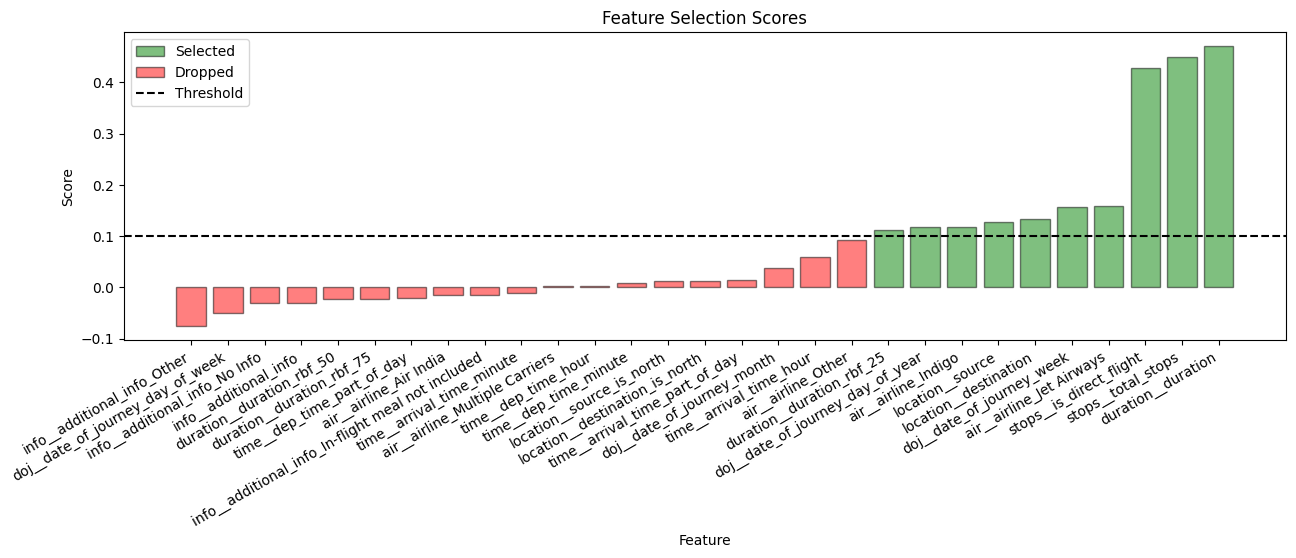

In [44]:
THRESHOLD = 0.1

selected_bar = None
dropped_bar = None
colors = ["red" if score < THRESHOLD else "green" for score in sorted_feat_imp.values()]


fig, ax = plt.subplots(figsize=(15, 4)) 

for i, (feature, score) in enumerate(sorted_feat_imp.items()):
	params = dict(
		x=i,
		height=score,
		edgecolor="black",
		alpha=0.5
	)
	
	if score < THRESHOLD:
		bar = ax.bar(
			color="red",
			**params
		)
		if not dropped_bar:
			dropped_bar = bar[0]
	else:
		bar = ax.bar(
			color="green",
			**params
		)
		if not selected_bar:
			selected_bar = bar[0]

thresh_line = ax.axhline(
	y=0.1,
	color="black",
	linestyle="--"
)

ax.set_xticks(
	ticks=range(len(sorted_feat_imp)),
	labels=list(sorted_feat_imp.keys()),
	rotation=30,
	ha="right"
)

ax.set(
	xlabel="Feature",
	ylabel="Score",
	title="Feature Selection Scores"
)

ax.legend(
	handles=[selected_bar, dropped_bar, thresh_line],
	labels=["Selected", "Dropped", "Threshold"],
	loc="upper left"
)

plt.show()

## The dataset went upto 31 columns after Feature Engineering
## The Feature Selection algorithm selected 13 features out of that